In [1]:
import xupy as xp
from numpy.ma import masked_array
import matplotlib.pyplot as plt 

# from ekarus.e2e.cascading_stage_ao_class import CascadingAO
from ekarus.e2e.single_stage_ao_class import SingleStageAO

from ekarus.e2e.utils import my_fits_package as myfits
from ekarus.e2e.utils.image_utils import reshape_on_mask, image_grid

import os.path as op


[XuPy] Device 0 available - GPU : `NVIDIA GeForce RTX 4060 Laptop GPU`
       Memory = 7805.56 MB | Compute Capability = 8.9
       Using CuPy 13.5.1 for acceleration.


In [2]:
from arte.utils.zernike_generator import ZernikeGenerator
from arte.types.mask import CircularMask

def define_zernike_basis(mask, max_radial_order:int):

    N = (max_radial_order+1)*(max_radial_order+2)//2-1
    circ_mask = CircularMask(mask.shape, maskRadius=max(mask.shape)//2)
    zg = ZernikeGenerator(circ_mask)
    zern_mat = xp.zeros([N,int(xp.sum(1-mask))])
    for i in range(N):
        noll = i+2
        zern = xp.asarray(zg.getZernike(noll))
        zern_mat[i,:] = zern[~mask]

    return zern_mat

In [3]:
prf = 'mag8_'
cascao = SingleStageAO(tn='offaxis_modalbase')
ma_atmo_phases,ma_res_phases, = cascao.load_telemetry_data(save_prefix=prf,data_keys=['atmo_phases','residual_phases'])
KL1 = myfits.read_fits(op.join(cascao.savecalibpath,'KL.fits'))
KL2 = myfits.read_fits(op.join(cascao.savecalibpath,'KL.fits'))

Initializing devices ...
Modulating 0 [lambda/D] with 0 modulation steps
Defining the detector subaperture masks ...
Modulating 10 [lambda/D] with 68 modulation steps
File /home/matte/git/ekarus/ekarus/simulations/results/offaxis_modalbase/mag8_atmo_phases.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/offaxis_modalbase/atmo_phases.fits instead
File /home/matte/git/ekarus/ekarus/simulations/results/offaxis_modalbase/mag8_residual_phases.fits not found, trying /home/matte/git/ekarus/ekarus/simulations/results/offaxis_modalbase/residual_phases.fits instead


In [45]:
def plot_masked_array(ma, id=None, mask=None):
    if mask is not None:
        ma_id = ma.copy()
        if id is not None:
            ma_id = ma[id]
        img = reshape_on_mask(ma_id,mask)
        marray = masked_array(xp.asnumpy(img), xp.asnumpy(mask))
    else:
        ma_id = ma.copy()
        if id is not None:
            ma_id = ma[id]
        marray = masked_array(ma_id.data,mask=ma_id.mask)
    plt.imshow(marray,origin='lower',cmap='RdBu')
    plt.colorbar()
    plt.axis('off')


def filter_modes(atmo_phases, KL, nModes2Filter=None, coeff=1.0):
    if nModes2Filter is not None:
        MM = KL[:nModes2Filter,:].T
    else:
        MM = (KL.T).copy()
    phase2modes = xp.linalg.pinv(MM)
    modes = phase2modes @ atmo_phases.T
    rec_phases = MM @ modes
    rec_phases *= coeff
    filt_phases = atmo_phases.T - rec_phases
    return filt_phases.T


def masked_array_to_matrix(ma_vec, mask):
    N = xp.shape(ma_vec)[0]
    data_len = int(xp.sum(1-mask))
    mat = xp.zeros([N,data_len])
    for i in range(N):
        mat[i,:] = xp.asarray(ma_vec[i].data)[~mask]
    return mat

In [5]:
def simulate_cascading_performance(atmo_phases, nModes_1st_stage:int, correction_1st_stage:float, 
                                   nModes_2nd_stage:int, correction_2nd_stage:float,
                                   normalize_to_perfect_psf:bool = True, modes=None, 
                                   lambdaRef:float=750e-9, Nframes:int=128, use_avg_field:bool=True,
                                   ):
    
    if modes is not None:
        MM1 = modes.copy()
        MM2 = modes.copy()
    else:
        MM1 = KL1.copy()
        MM2 = KL2.copy()
    filt_phases_1st_stage = filter_modes(atmo_phases, MM1, nModes_1st_stage, coeff=correction_1st_stage)
    filt_phases_2nd_stage = filter_modes(filt_phases_1st_stage, MM2, nModes_2nd_stage, coeff=(1-(1-correction_2nd_stage)/(1-correction_1st_stage)))
    filt_phases_perfect_stage = filter_modes(atmo_phases, MM1, max(nModes_1st_stage,nModes_2nd_stage))

    atmo_phases_in_rad = atmo_phases[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_1st_in_rad = filt_phases_1st_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_2nd_in_rad = filt_phases_2nd_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef
    filt_perf_in_rad = filt_phases_perfect_stage[-Nframes:,:] * (2*xp.pi)/lambdaRef

    _, atmo_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, stage1_profile, pix_dist = cascao.get_contrast(filt_1st_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, stage2_profile, pix_dist = cascao.get_contrast(filt_2nd_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
    _, perf_stage_profile, pix_dist = cascao.get_contrast(filt_perf_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

    plt.figure()
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(atmo_profile), label='atmo')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(stage1_profile), label=f'1st stage: {nModes_1st_stage:1.0f} modes @ {correction_1st_stage*1e+2:1.0f}%')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(stage2_profile), label=f'2nd stage: {nModes_2nd_stage:1.0f} modes @ {correction_2nd_stage*1e+2:1.1f}%')
    plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(perf_stage_profile), label=f'perfect stage: {nModes_1st_stage:1.0f} modes @ 100%')
    plt.legend()
    plt.grid()
    plt.xlim([0,24])
    plt.ylim([1e-7,1e-2])
    plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
    plt.xlabel(r'$\lambda/D$')
    plt.yscale('log')
    plt.title('Contrast with perfect coronograph\nand partial correction')

In [6]:
# atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
# atmo_phase = atmo_phases[0,:]
# rec_phase = fourier_inv @ atmo_phase
# # rec_phase = (rec_mode * D) @ U.T
# rec_phase =  fourier_mat.T @ rec_phase
# mask = cascao.cmask.copy()


# plt.figure(figsize=(18,4))
# plt.subplot(1,3,1)
# plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.subplot(1,3,2)
# plt.imshow(xp.asnumpy(reshape_on_mask(rec_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase-rec_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()

In [7]:
atmo_phases = masked_array_to_matrix(ma_atmo_phases, cascao.cmask)
res_phases = masked_array_to_matrix(ma_res_phases, cascao.cmask)
# # simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=400, correction_1st_stage=0.95, nModes_2nd_stage=100, correction_2nd_stage=0.995)
# atmo_phase = atmo_phases[0,:]

# rec_mode = zern_mat @ atmo_phase
# rec_phase = zern_inv @ rec_mode
# mask = cascao.cmask.copy()


# plt.figure(figsize=(18,4))
# plt.subplot(1,3,1)
# plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.subplot(1,3,2)
# plt.imshow(xp.asnumpy(reshape_on_mask(rec_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()
# plt.subplot(1,3,3)
# plt.imshow(xp.asnumpy(reshape_on_mask(atmo_phase-rec_phase,mask)),origin='lower',cmap='RdBu')
# plt.colorbar()

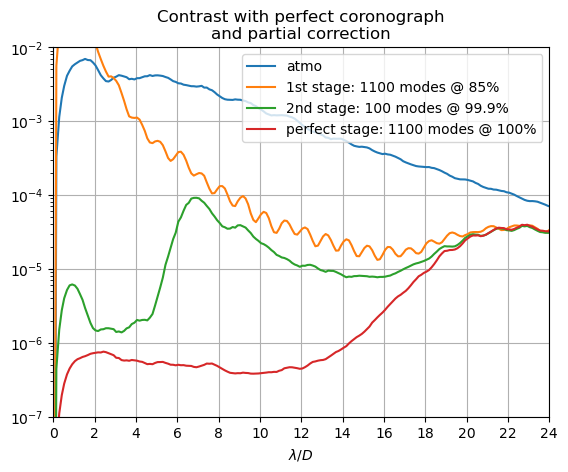

In [8]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=1100, correction_1st_stage=0.85, nModes_2nd_stage=100, correction_2nd_stage=0.999)

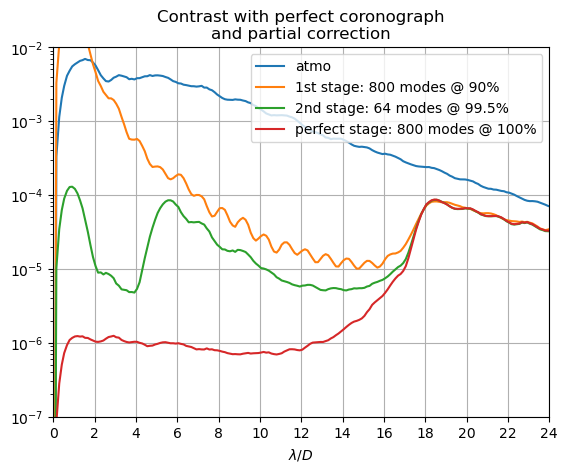

In [9]:
simulate_cascading_performance(atmo_phases=atmo_phases, nModes_1st_stage=800, correction_1st_stage=0.9, nModes_2nd_stage=64, correction_2nd_stage=0.995)

In [10]:
lambdaRef = 750e-9
N = 128

filt1100_phases = filter_modes(atmo_phases, KL1, 1100)
atmo_phases_in_rad = atmo_phases[-N:,:] * (2*xp.pi)/lambdaRef
res_phases_in_rad = res_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt1100_phases_in_rad = filt1100_phases[-N:,:] * (2*xp.pi)/lambdaRef

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8)

In [11]:
# ssao = SingleStageAO(tn='cascading_8m_ssao_ref')
# psf1, pix_dist = ssao.plot_contrast(lambdaRef, frame_ids=xp.arange(ssao.Nits-128,ssao.Nits).tolist(), save_prefix='f1kHz_', oversampling=8)
# psf2, pix_dist = ssao.plot_contrast(lambdaRef, frame_ids=xp.arange(ssao.Nits-128,ssao.Nits).tolist(), save_prefix='f4kHz_', oversampling=8)
# plt.figure()
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='seeing limited')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf1), label='baseline (1 kHz correction)')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(psf2), label='goal (4 kHz correction)')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='ideal (perfect correction)')
# plt.legend()
# plt.grid()
# plt.xlim([0,24])
# plt.ylim([1e-7,1e-2])
# plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
# plt.xlabel(r'$\lambda/D$')
# plt.yscale('log')
# plt.title('Contrast @ 750nm\nSingle stage, perfect coronograph')

In [12]:

# atmo_noTT_phases = filter_modes(atmo_phases, KL1, 2)
filt10_phases = filter_modes(atmo_phases, KL1, 10)
filt100_phases = filter_modes(atmo_phases, KL1, 100)
filt200_phases = filter_modes(atmo_phases, KL1, 200)
filt500_phases = filter_modes(atmo_phases, KL1, 500)
filt800_phases = filter_modes(atmo_phases, KL1, 800)

In [13]:

# filt5_phases_in_rad = filt5_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt10_phases_in_rad = filt10_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt100_phases_in_rad = filt100_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt200_phases_in_rad = filt200_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt500_phases_in_rad = filt500_phases[-N:,:] * (2*xp.pi)/lambdaRef
filt800_phases_in_rad = filt800_phases[-N:,:] * (2*xp.pi)/lambdaRef

In [14]:
def get_residual(phase):
    phase_std = xp.std(phase,axis=1)
    return xp.sqrt(xp.mean(phase_std**2))

Text(0.5, 1.0, 'Residual: 25.9 nm')

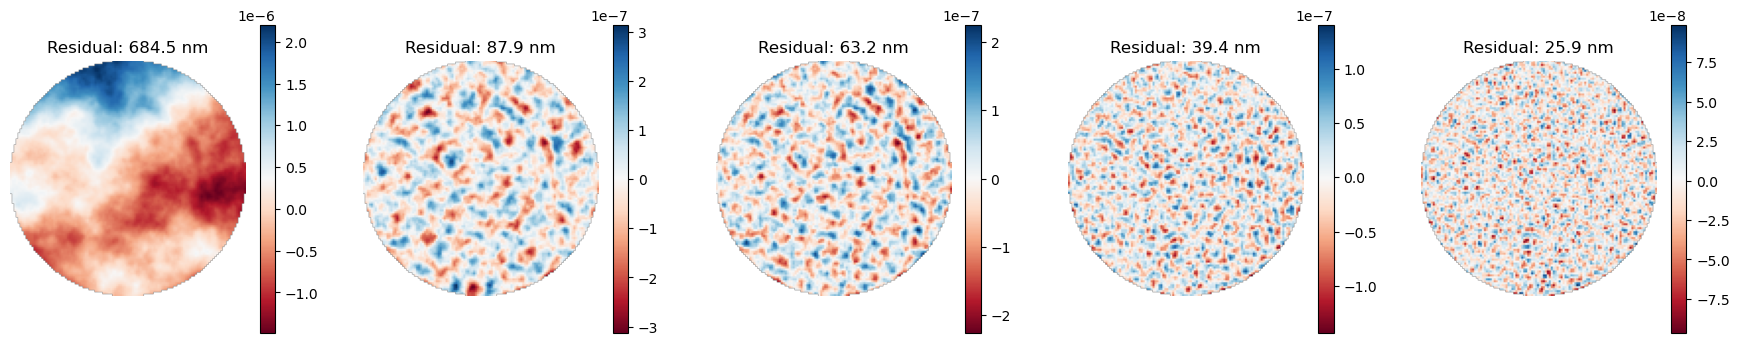

In [15]:
plt.figure(figsize=(22,4))
plt.subplot(1,5,1)
plot_masked_array(atmo_phases,-1, cascao.cmask)
plt.title(f'Residual: {get_residual(atmo_phases)*1e+9:1.1f} nm')
plt.subplot(1,5,2)
plot_masked_array(filt100_phases,-1, cascao.cmask)
plt.title(f'Residual: {get_residual(filt100_phases)*1e+9:1.1f} nm')
plt.subplot(1,5,3)
plot_masked_array(filt200_phases,-1, cascao.cmask)
plt.title(f'Residual: {get_residual(filt200_phases)*1e+9:1.1f} nm')
plt.subplot(1,5,4)
plot_masked_array(filt500_phases,-1, cascao.cmask)
plt.title(f'Residual: {get_residual(filt500_phases)*1e+9:1.1f} nm')
plt.subplot(1,5,5)
plot_masked_array(filt1100_phases,-1, cascao.cmask)
plt.title(f'Residual: {get_residual(filt1100_phases)*1e+9:1.1f} nm')

In [16]:
normalize_to_perfect_psf = True
use_avg_field = False

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
# _, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile500, pix_dist = cascao.get_contrast(filt500_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

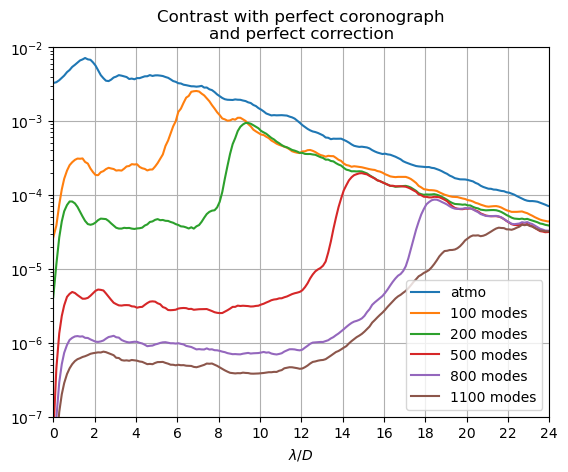

In [17]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile500), label='500 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [18]:
normalize_to_perfect_psf = True
use_avg_field = True

_, rad_profile, pix_dist = cascao.get_contrast(atmo_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile10, pix_dist = cascao.get_contrast(filt10_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile100, pix_dist = cascao.get_contrast(filt100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile200, pix_dist = cascao.get_contrast(filt200_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile800, pix_dist = cascao.get_contrast(filt800_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)
_, rad_profile1100, pix_dist = cascao.get_contrast(filt1100_phases_in_rad, oversampling=8, normalize_to_perfect_psf=normalize_to_perfect_psf, use_avg_field=use_avg_field)

Text(0.5, 1.0, 'Contrast with perfect coronograph\nand perfect correction')

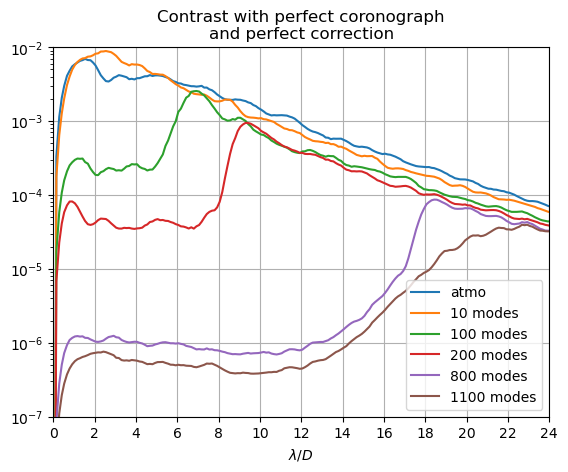

In [19]:
plt.figure()#figsize=(16,5))
# plt.subplot(1,2,1)
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), label='atmo')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile5), label='5 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile10), label='10 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile100), label='100 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 modes')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 modes')
plt.legend()
plt.grid()
plt.xlim([0,24])
plt.ylim([1e-7,1e-2])
plt.xticks(xp.asnumpy(xp.arange(0,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('Contrast with perfect coronograph\nand perfect correction')

In [ ]:

def define_target_roi(pupil, iwa, owa, oversampling:int, symmetric:bool=False, heightInLambdaOverD=None):
    mask_shape = max(pupil.shape)
    padded_pupil = xp.pad(1-pupil.copy(), pad_width=int((mask_shape*(oversampling-1)//2)), mode='constant', constant_values=0.0)
    X,Y = image_grid(padded_pupil.shape,recenter=True)
    rho = xp.sqrt(X**2+Y**2)
    if symmetric is True:
        where = (rho <= owa*oversampling) * (rho >= iwa*oversampling)
    else:
        where = (rho <= owa*oversampling) * (X >= iwa*oversampling) 
    if heightInLambdaOverD is not None:
        where *= (abs(Y) < heightInLambdaOverD/2*oversampling)
    return where

def get_apodizer_phase(pupil, target_contrast, oversampling:int=4,
                       max_its:int=20, beta:float=0, IF=None):
    N = max(pupil.shape)
    pad_width = N*(oversampling-1)//2
    pad_pupil = xp.pad(pupil, pad_width, mode='constant', constant_values=0.0)
    dark_zone = target_contrast < 0.1

    a = pad_pupil.copy().astype(xp.complex64)
    old_ff = None

    if IF is not None:
        Rec = xp.linalg.pinv(IF)
    for it in range(max_its):
        ff = xp.fft.fftshift(xp.fft.fft2(a))
        if not xp.any(xp.abs(ff)**2 / xp.max(xp.abs(ff)**2) > target_contrast):
            break
        new_ff = ff.copy()
        if beta != 0 and old_ff is not None:
            new_ff[dark_zone] = old_ff[dark_zone] * beta - new_ff[dark_zone] * (1 + beta)
        else:
            new_ff[dark_zone] = 0
        old_ff = new_ff.copy()
        a = xp.fft.ifft2(xp.fft.ifftshift(new_ff))
        a[~pad_pupil.astype(bool)] = 0
        phase = xp.angle(a)
        if IF is not None:
            cmd = Rec @ phase[pad_pupil.astype(bool)]
            phase = reshape_on_mask(IF @ cmd,(1-pad_pupil).astype(bool))
        a = xp.abs(pad_pupil) * xp.exp(1j*(phase),dtype=xp.complex64) 
    psf = xp.abs(ff)**2
    ref_psf = xp.abs(xp.fft.fftshift(xp.fft.fft2(pupil)))**2
    contrast =  psf / xp.max(ref_psf)
    if it == max_its-1:
        print(f'Maximum number of iterations ({max_its:1.0f}) reached, worst contrast in dark hole is: {xp.log10(xp.max(contrast[dark_zone])):1.1f}')
    else:
        print(f'Apodizer computed in {it:1.0f} iterations: average contrast in dark hole is {xp.mean(xp.log10(contrast[dark_zone])):1.1f}, Strehl is {xp.max(psf)/xp.max(ref_psf)*1e+2:1.2f}%')
    pad_phase = xp.angle(a)
    phase = reshape_on_mask(pad_phase[pad_pupil.astype(bool)],(1-pupil).astype(bool))
    return phase

def calc_psf(ef, oversampling:int=8):
    pad_width = int((max(ef.shape)*(oversampling-1)//2))
    pad_ef = xp.pad(ef, pad_width=pad_width, mode='constant', constant_values=0.0)
    ff = xp.fft.fftshift(xp.fft.fft2(pad_ef))
    return xp.real(ff * xp.conj(ff))

def show_psf(psf, norm=None, oversampling:int=8, title:str='', ext=0.3, vmin=-10):
    pixelSize = 1/oversampling
    imageHalfSizeInPoints= psf.shape[0]/2
    roi= [int(imageHalfSizeInPoints*(1-ext)), int(imageHalfSizeInPoints*(1+ext))]
    psfZoom = psf[roi[0]: roi[1], roi[0]:roi[1]]
    sz = psfZoom.shape
    if norm is None:
        norm = xp.max(psf)
    plt.imshow(xp.asnumpy(xp.log10(psfZoom/norm)), extent=
               [-sz[0]/2*pixelSize, sz[0]/2*pixelSize,
               -sz[1]/2*pixelSize, sz[1]/2*pixelSize],
               origin='lower',cmap='inferno',vmin=vmin,vmax=0)
    plt.xlabel(r'$\lambda/D$')
    plt.ylabel(r'$\lambda/D$')
    cbar= plt.colorbar()
    cbar.ax.set_title('Contrast')
    plt.title(title)

# from arte.utils.radial_profile import computeRadialProfile
def get_one_sided_contrast(cmask, residual_phases_in_rad, 
                           iwa:float,oversampling:int=10):
    N = residual_phases_in_rad.shape[0]
    res_phases = xp.array(residual_phases_in_rad)
    padding_len = int(cmask.shape[0]*(oversampling-1)/2)
    pup_mask = xp.pad(cmask, padding_len, mode='constant', constant_values=1)
    psf_stack = []
    field_amp = 1-pup_mask
    psf = abs(xp.fft.fftshift(xp.fft.fft2(field_amp)))**2
    max_psf = xp.max(psf)
    for k,res_phase in enumerate(res_phases):
        print(f'\rComputing contrast: processing frame {k+1:1.0f}/{N:1.0f}',end='\r',flush=True)
        phase_2d = reshape_on_mask(res_phase, pup_mask)
        apo_field = field_amp * xp.exp(1j*phase_2d, dtype=xp.complex64)
        coro_focal_plane_ef = xp.fft.fftshift(xp.fft.fft2(apo_field))
        coro_psf = abs(coro_focal_plane_ef)**2
        coro_psf /= max_psf #xp.max(coro_psf)
        psf_stack.append(coro_psf)
    psf_stack = xp.array(psf_stack)
    psf_rms = xp.sqrt(xp.mean(psf_stack**2,axis=0))
    H,W = psf_rms.shape
    # xc = W/2+iwa*oversampling
    # rad_profile,dist = computeRadialProfile(xp.asnumpy(psf_rms[:,xc:]),H/2,0)
    # pix_dist = dist/oversampling+iwa
    rad_profile = psf_rms[H/2,:]
    pix_dist = (xp.arange(psf_rms.shape[1])-psf_rms.shape[1]/2)/oversampling
    plt.figure()
    # plt.imshow(xp.asnumpy(xp.log(xp.sqrt(psf_rms))),origin='lower',cmap='inferno',vmin=-8,vmax=0)
    # plt.colorbar()
    show_psf(psf_rms,ext=0.7,vmin=-8)
    return xp.array(psf_rms), xp.array(rad_profile), xp.array(pix_dist)

Apodizer computed in 2470 iterations: average contrast in dark hole is -9.1, Strehl is 73.97%


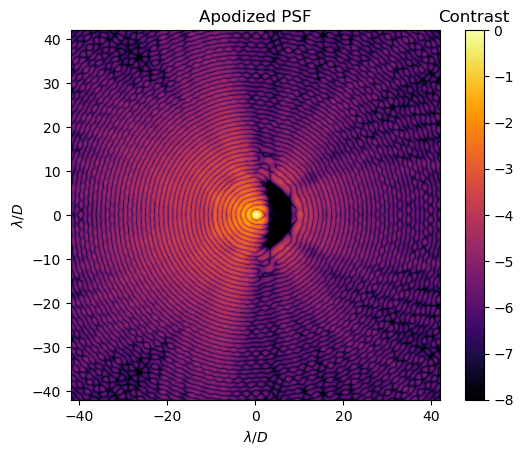

In [ ]:
oversampling = 4
iwa = 3
pupil = 1-cascao.cmask.copy()
dark_zone = define_target_roi(pupil, iwa=iwa, owa=8, oversampling=oversampling)
target_contrast = xp.ones([pupil.shape[0]*oversampling,pupil.shape[1]*oversampling])
target_contrast[dark_zone] = 1e-7
app_phase = get_apodizer_phase(pupil, target_contrast, oversampling=oversampling, max_its=5000, beta=0.975)
app_psf = calc_psf(pupil*xp.exp(1j*app_phase,dtype=xp.complex64))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
show_psf(app_psf,title='Apodized PSF',vmin=-8,ext=0.7)
plt.subplot(1,2,2)
plot_masked_array(app_phase[~cascao.cmask],mask=cascao.cmask)
plt.title('Apodizer phase')

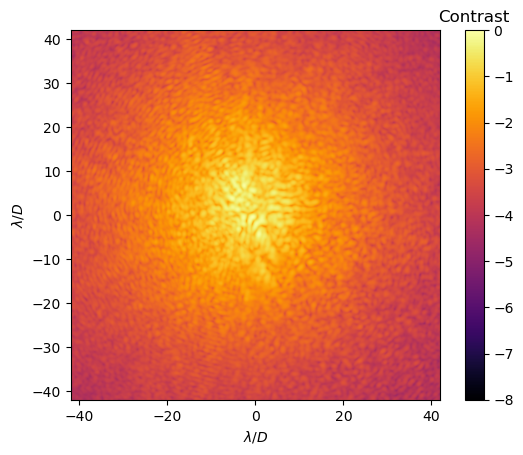

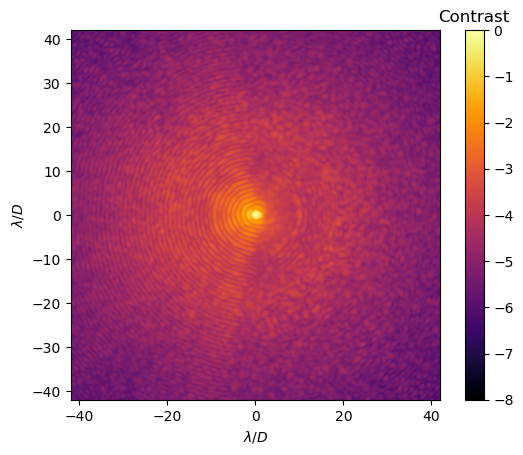

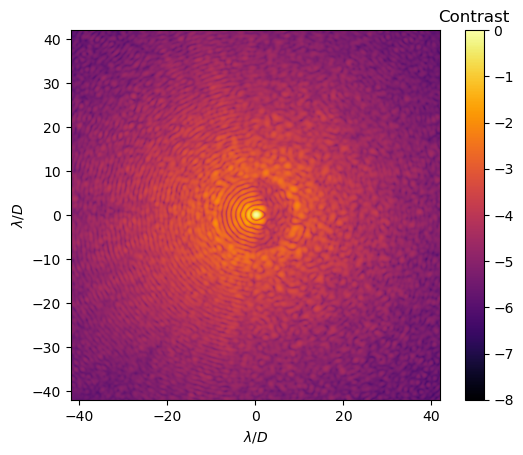

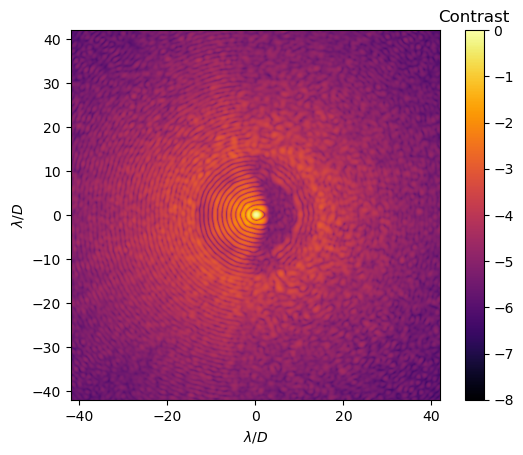

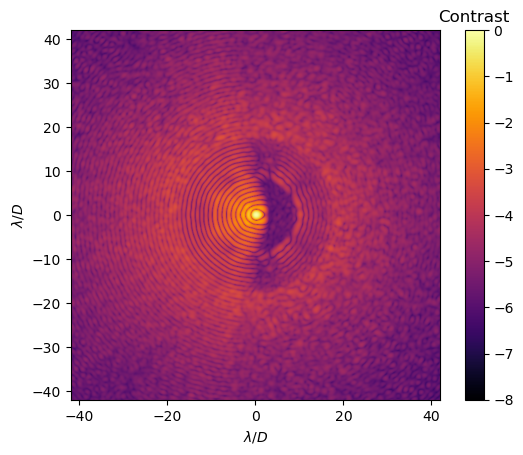

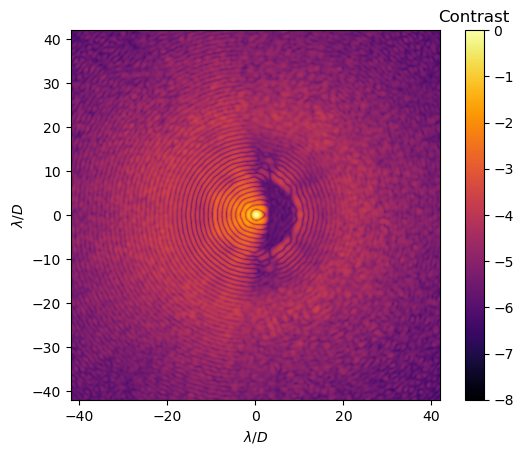

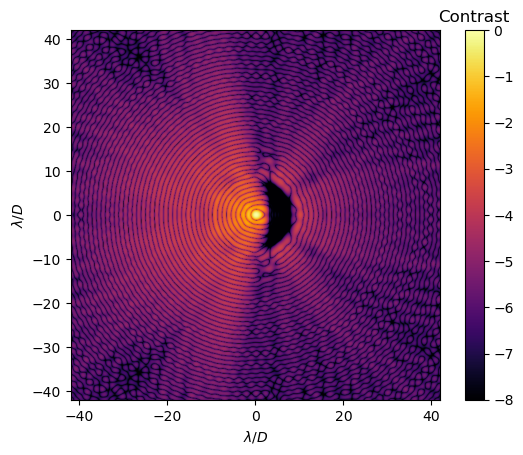

In [38]:
dl_phases_apo = xp.tile(app_phase[pupil.astype(bool)],[int(xp.shape(atmo_phases_in_rad)[0]),1])
atmo_phases_apo = atmo_phases_in_rad + dl_phases_apo
res_phases_apo = res_phases_in_rad + dl_phases_apo
# filt10_phases_apo = filt10_phases_in_rad + dl_phases_apo
# filt100_phases_apo = filt100_phases_in_rad + dl_phases_apo
filt200_phases_apo = filt200_phases_in_rad + dl_phases_apo
filt500_phases_apo = filt500_phases_in_rad + dl_phases_apo
filt800_phases_apo = filt800_phases_in_rad + dl_phases_apo
filt1100_phases_apo = filt1100_phases_in_rad + dl_phases_apo

_, rad_profile, pix_dist = get_one_sided_contrast(cascao.cmask, atmo_phases_apo, iwa=iwa, oversampling=8)
_, rad_profile_res, pix_dist = get_one_sided_contrast(cascao.cmask,res_phases_apo, iwa=iwa, oversampling=8)
# _, rad_profile10, pix_dist = get_one_sided_contrast(cascao.cmask,filt10_phases_apo, iwa=iwa, oversampling=8)
# _, rad_profile100, pix_dist = get_one_sided_contrast(cascao.cmask,filt100_phases_apo, iwa=iwa, oversampling=8)
_, rad_profile200, pix_dist = get_one_sided_contrast(cascao.cmask,filt200_phases_apo, iwa=iwa, oversampling=8)
_, rad_profile500, pix_dist = get_one_sided_contrast(cascao.cmask,filt500_phases_apo, iwa=iwa, oversampling=8)
_, rad_profile800, pix_dist = get_one_sided_contrast(cascao.cmask,filt800_phases_apo, iwa=iwa, oversampling=8)
_, rad_profile1100, pix_dist = get_one_sided_contrast(cascao.cmask,filt1100_phases_apo, iwa=iwa, oversampling=8)
_, rad_profile_dl, pix_dist = get_one_sided_contrast(cascao.cmask,dl_phases_apo, iwa=iwa, oversampling=8)

Text(0.5, 1.0, 'APP contrast vs correction level')

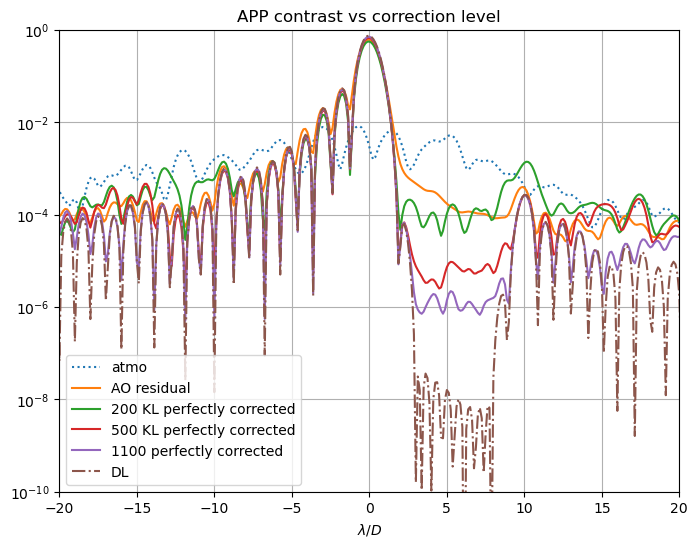

In [40]:
plt.figure(figsize=(8,6))
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile), ':', label='atmo')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile_res), label='AO residual')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile200), label='200 KL perfectly corrected')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile500), label='500 KL perfectly corrected')
# plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile800), label='800 perfectly corrected')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile1100), label='1100 perfectly corrected')
plt.plot(xp.asnumpy(pix_dist), xp.asnumpy(rad_profile_dl), '-.', label='DL')
plt.legend()
plt.grid()
plt.xlim([-20,20])
plt.ylim([1e-10,1.0])
# plt.xticks(xp.asnumpy(xp.arange(iwa,26,2)))
plt.xlabel(r'$\lambda/D$')
plt.yscale('log')
plt.title('APP contrast vs correction level')